<h2 style="background-color:powderblue;color:brown;"> <center> Short-term Refresher Course in Radar 2024 </center> </h2> <hr>
<h1 style="color:tomato;"> <center>  Severe Weather Analysis ("Hail")</center> </h1>
<h3 style="color:Blue;"><center> Hands-on Discussion Material with codes [27th September 2024 10.30-11.30 UTC]</center> </h3>
<h4 style="color:Purple;"> <center>B. Arul Malar Kannan,Scientist IMD </center> </h4> <h5><center> ba.kannan@imd.gov.in </center><hr></h5> <p>We all know,  Weather radar gives more important information of near real time events and is the best tool for operational nowcasting by profiling/scanning the hemispherical atmosphere surrounding the radar center by actively sending a microwave signal and processing the backscattering signals.</p><p>  The meteorological radars are primarily aimed for detecting precipitation and related phenomena.  However, by virtue signatures of all objects present around are invariably present. </p>
<p>  The present discussion is aimed to analyze the acquired radar data with specific reference towards Hail-Storm features, a continuation of the earlier Workshop.</p>
<p>  Open source Pythonic radar libraries ARM-PyART, Pyhail, Matplotlib, Pandas, Scipy, Cartopy have been used enabling the user to correlate and analyse the previous theoritical discussion session. The theoratical session material/ presentations are shared through the organizers.</p>
<p></p>
<p>  <h5> The customized code and data is shared for research purposes. While reusing India Meteorological Department, MoES shall be credited </h5></p>

### STEP - 1 : Import required PYTHON Libraries

In [2]:
#IMPORT REQUIRED PYTHON LIBRARIES
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyart
from pyhail import mesh_grid
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) 
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore",category=UserWarning)

### Step 2: Read the Radar Data and understand its contents

In [3]:
#READ THE FILE and get its contents using pyART
InputFile='data/2024050210404500dBZ.vol'
radar=pyart.aux_io.read_rainbow_wrl(InputFile)
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (3609,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (3609,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (3609, 1667)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Reflectivity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
fixed_angle:
	data: <ndarray of type: float64 and shape: (10,)>
	long_name: Target an

<head>
    <h1>RAW DATA - The Usable Level II</h1>
    </head>
    <p>
    The pulse radar gets a basic resolution along the scanned range normally to the measure of the pulse width.  This is normally 150m [for 1micro seconds PW] and 300m[for a 2micro second PW].  The the angular resolution is approximately $1^0$ x $1^0$.  This base resolution of the entire volume is called a range bin.  All these range bins stacked along a particular direction of azimuth or elevation is termed as a ray, a collection of rays constitutes a sweep.  The sweep along a particular fixed elevation angle is called a PPI scan and the one with a fixed azimuth is termed as a RHI scan. The collection of these sweeps constitutes a volume scan.
    IMD radars perform two types of scan every ten minutes.  One for long range surveillance where the  reflectivity field is alone used and another volumetric data with ten sweeps, elevation angles 0.2, 1.5, 2.0, 3.0, 4.5, 6.0, 9.0, 12.0, 16.0, 21.0,  scan range 250km useful for weather study with all basic moments viz., reflectivity, velocity, spectrum width availability [SK Roy Bhowmick etal 2011]. 
    Present Day Dual Polarization techniques provides additional information or moments determined from the target namely, Differential reflectivity, Differential Phase, Correlation coefficient.
   </p>

In [4]:
Latt=radar.latitude['data'][0]
Long=radar.longitude['data'][0]
Rdr_Name=radar.metadata['instrument_name']
Obs_time=''.join(filter(lambda i: i.isdigit(), radar.time['units']))
El_low=radar.fixed_angle['data'][0]
print(Latt,Long, Rdr_Name,Obs_time[:])

13.072833 80.288333  20240502104045


<head>
    <h2>RADAR - Data storage and evolving evolving uniform Formats</h2>
    </head>
   <p> CF Conventions & Hirearchial Formats</p>


In [5]:
ho=radar.altitude['data']/1000
Rmax=int(np.floor(np.mean(radar.range['data'])/1000))*2
BW=1.0
Elev=(radar.elevation['data'])[0::360]
print(ho,Rmax,BW, Elev)

[0.053] 250 1.0 [ 0.2  0.2  1.   2.   3.   4.5  6.   9.  12.  16.  21. ]


<head>
    <h2>RADAR - Range Height Equation and Range Height Diagram of the data</h2>
    </head>
   <p> 
    Height of the radar beam at a slant range R from the radar location at a elevation angle $\phi$ is given by<blockquote><div>
    <strong>$h_R = \sqrt{R^2+(k_e R)^2+2 k_e R\sin\phi}- k_e R + h_0$ </strong><br /></div></blockquote>
  where,<br />
    	$k_e = 4/3$    <em>for a 4/3 effective earth radius model</em> <br />
    	$\phi$ is the elevation angle <br />
    	$h_0$ is the altitude (till the center of the radiating antenna feed)<br />
    </p>
    <img src="data/picture1.png", ,width=50%,height=50%>

Elevation angles in the present data is: [ 0.2  0.2  1.   2.   3.   4.5  6.   9.  12.  16.  21. ]


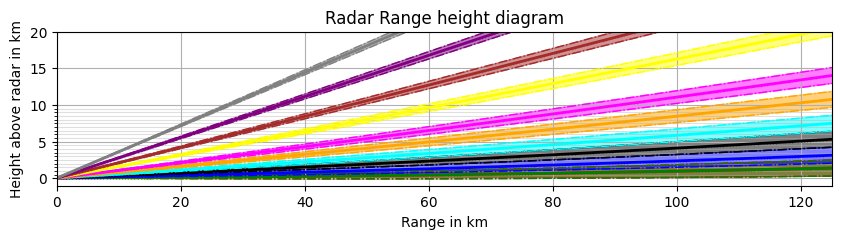

In [6]:
eee=Elev

print("Elevation angles in the present data is:", eee)
R=6371.0
k=4./3.
BW=1.0
elev=0.0
Rbin=0.5
def f(ra,p):
    return (((ra)**2.0)+((k*R)**2.0)+2*k*R*ra*np.sin(p))**0.5-k*R+ho


def rhii(elev,coo):
    phi=elev*np.pi/180.
    phi_ = np.radians(elev+BW/2.0)
    phi___ =np.radians(elev-BW/2.0)
    r=np.arange(0,Rmax,Rbin)
    h=np.zeros(len(r))
    h_ =np.zeros(len(r))
    h___ =np.zeros(len(r))
    for iii in np.arange(len(r)):
        h[iii]=f(r[iii],phi)
        h_[iii]=f(r[iii],phi_)
        h___[iii]=f(r[iii],phi___)
        bb=np.pi*(((h_-h___)/2)**2.)*r*20
    er=h_-h___
    ax.plot(r,h,linestyle='-', linewidth=2, marker='o',markersize=.2,color=coo, label=elev)
    ax.plot(r,h_,linestyle='-.', linewidth=1,color=coo) 
    ax.plot(r,h___,linestyle='-.', linewidth=1,color=coo) 
    ax.fill_between(r,h_, h___, color=coo, alpha=0.5 )
    

fig, ax = plt.subplots(figsize=(10,2))

coo=['red','green','blue','black','cyan','orange','magenta','yellow','brown','purple','gray','red','green','blue','cyan','k']
for ii in np.arange(len(eee)):
    rhii(eee[ii], coo[ii])
ax.set_xlabel('Range in km')
ax.set_ylabel('Height above radar in km')
ax.set_title('Radar Range height diagram')
ax.set_ylim([-1,20])
ax.set_xlim([0,Rmax/2])
minor_ticks=np.arange(0,10,0.5)
major_ticks=np.arange(0,10,1)

ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.4)
ax.grid()
#plt.show()

<head>
    <h4>Assignment: <p>1. From which start range to what end range Hail Detection is feasible? </p>
    <p> 2. When the maximum cloud detection is feasible with negative elevation angles why there is a restriction... Any comments? </p></h4>
    </head> 

<p>
Irrespective of the above calculation for the beam propagation still artifact lingers out of the anamolous propagation conditions where the refractive index variations are not to the normal way leading to sub/super refractions
    </p>
  <div class="left">
       <img src="data/picture2.png", ,width=50%,height=50%/><br></a>
  </div>

### Step 3: Create a PPI & RHI Plot for the observed moments

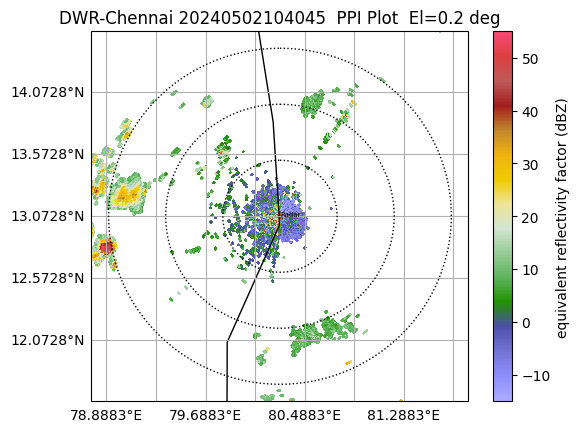

In [7]:
# Setup the RadarMapDisplay and add our projection
display = pyart.graph.RadarMapDisplay(radar)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

#Visualize the reflectivity field, using the lowest sweep with
# latitude and longitude lines
display.plot_ppi_map( "reflectivity", 0, ax=ax, vmin=-15, vmax=55.0, cmap='pyart_Theodore16',
    lon_lines=np.arange(Long-1.4, Long+1.5, 0.4),
    lat_lines=np.arange(Latt-1.5, Latt+1.5, 0.5),
    title="DWR-Chennai "+Obs_time + "  PPI Plot  El=" +str(El_low) + " deg"
    
)
display.plot_range_rings([50, 100, 150], ax=ax, col='k',ls=':', lw=1)
# Plot our site location on top of the radar image
x=[Long]
y=[Latt]
nnn=['Radar']
ax.scatter(Long, Latt,color="r",marker='*',alpha=0.5,s=20) #s,o,^,d,v,*,+6,x,X,d,D,
for i, txt in enumerate(nnn):
    ax.annotate(txt, (x[i], y[i]),fontsize=5)
#plt.savefig('CNI'+Obs_time+'.png',bbox_inches='tight')

<head><h4>Assignment: <p>3. Comment on the obsertvations of the above plot </p></h4>  </head>
<p> Hint:  Severe Weather Signature Based on Radar Reflectivity factor also see the RHI Plots below</p>

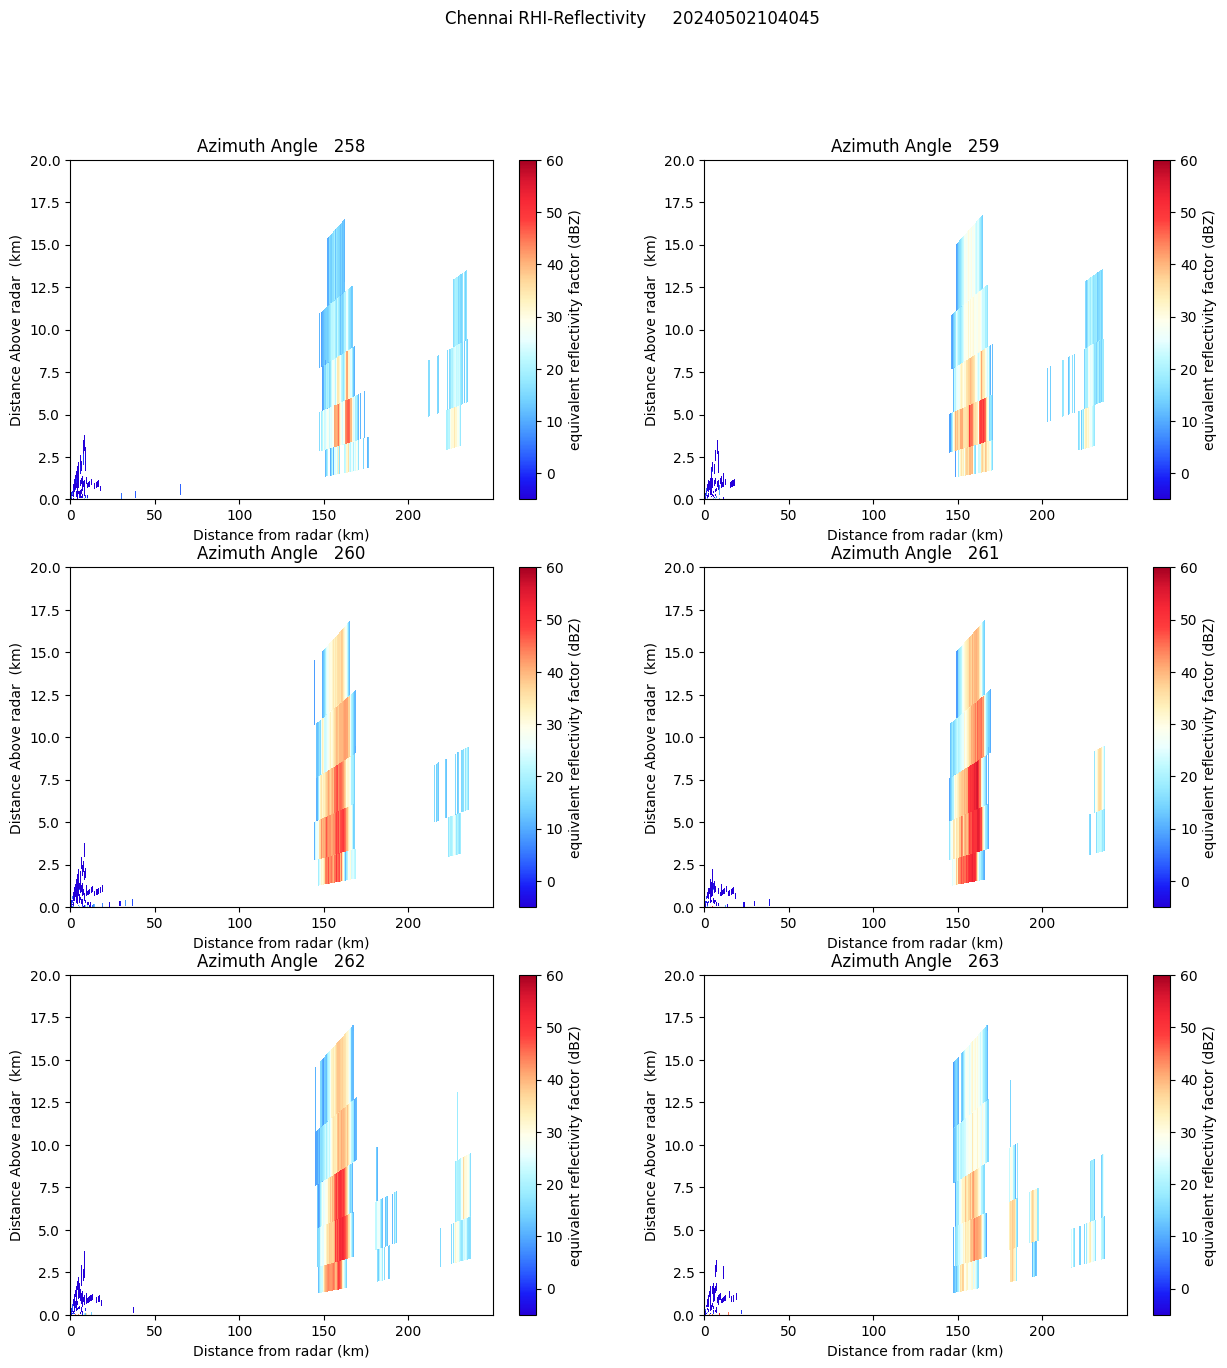

In [8]:
AZI=[258,259,260,261,262,263]
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(321)
display.plot_azimuth_to_rhi('reflectivity', AZI[0], ax=ax1, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[0]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
ax2 = fig.add_subplot(322)
display.plot_azimuth_to_rhi('reflectivity', AZI[1], ax=ax2, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[1]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
ax3 = fig.add_subplot(323)
display.plot_azimuth_to_rhi('reflectivity', AZI[2], ax=ax3, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[2]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
ax4 = fig.add_subplot(324)
display.plot_azimuth_to_rhi('reflectivity', AZI[3], ax=ax4, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[3]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
ax5 = fig.add_subplot(325)
display.plot_azimuth_to_rhi('reflectivity', AZI[4], ax=ax5, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[4]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
ax6 = fig.add_subplot(326)
display.plot_azimuth_to_rhi('reflectivity', AZI[5], ax=ax6, vmin=-5, vmax=60., title="Azimuth Angle   "+str(AZI[5]), cmap='pyart_BuDRd18')
plt.ylim([0, 20]);
fig.suptitle('Chennai RHI-Reflectivity     '+ Obs_time);

### Step 4: Classification of Events

In [9]:
#Convert the data to Geo-referred Grid
radarg = radar.extract_sweeps([0])
# interpolate to grid
grid = pyart.map.grid_from_radars(
    (radarg,),
    grid_shape=(1, 201, 201),
    grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)),
    fields=["reflectivity"],
)
# get dx dy
dx = grid.x["data"][1] - grid.x["data"][0]
dy = grid.y["data"][1] - grid.y["data"][0]

gridm = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 201, 201),
    grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)),
    fields=["reflectivity"],
    weighting_function='Barnes',
    gridding_algo='map_gates_to_grid',
    roi_func='constant', constant_roi=2000,
)

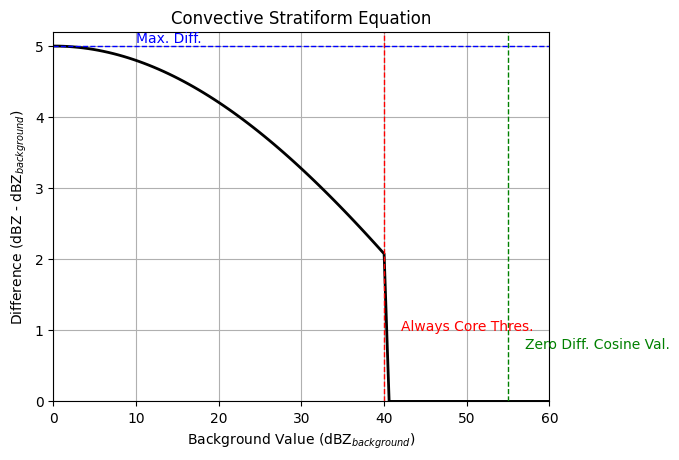

In [10]:
#Understanding the Cosine algorithm proposed by Houze 1973 revised in 1984; steiner 1995, Yuter 1997 dZcc, Zbg, Zt,  
pyart.graph.plot_convstrat_scheme(
    always_core_thres=40,
    use_cosine=True,
    max_diff=5,
    zero_diff_cos_val=55,
)

<head> <h4> Assignment: <p> 4. Understand the spatial-scale dependence of classification parameter </p> </h4>  </head>
<p> Hint:  Refer additional parameters in the Yuter Algorithm an extension of cosine algorithm proposed by Houze 1973...  </p>

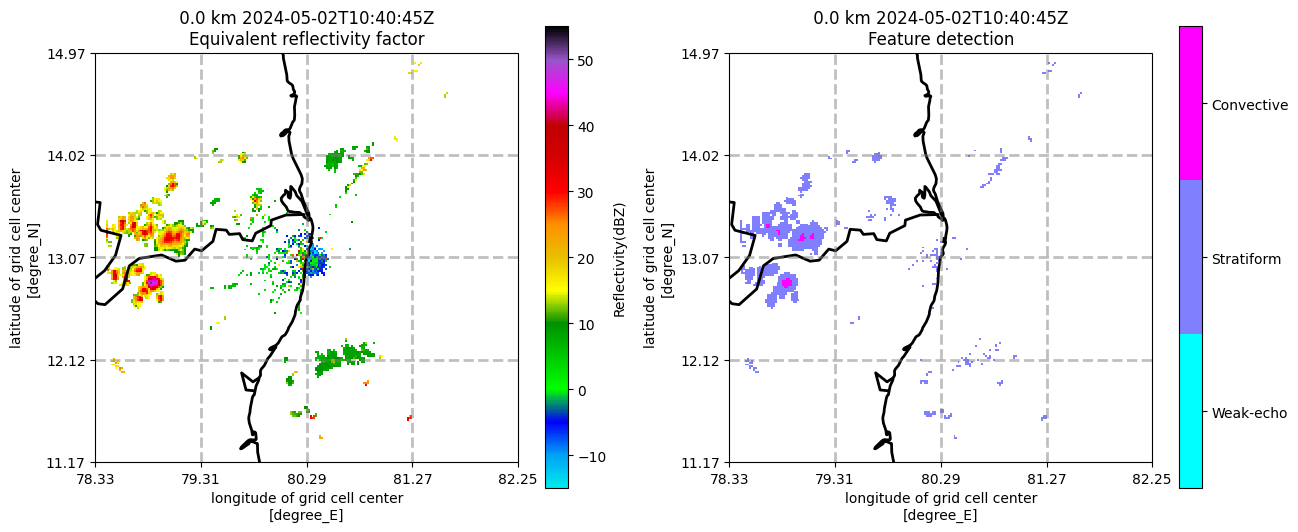

In [11]:
# let's do a classification  for convective stratiform classification with the parameters extracted for the lowest sweep 
convsf_dict = pyart.retrieve.conv_strat_yuter( grid, refl_field="reflectivity",
    #dx=dx, dy=dy,
    dx=3000, dy=3000,
    always_core_thres=40,
    bkg_rad_km=15,
    use_cosine=True,
    max_diff=5,
    zero_diff_cos_val=55,
    weak_echo_thres=10,
    max_conv_rad_km=2,)

# Add the convective_stratiform classification as an additiona parameter to grid object
# mask zero values (no surface echo)
convsf_masked = np.ma.masked_equal(convsf_dict["feature_detection"]["data"], 0)
# mask 3 values (weak echo)
convsf_masked = np.ma.masked_equal(convsf_masked, 3)
# add dimension to array to add to grid object
convsf_dict["feature_detection"]["data"] = convsf_masked
# add field
grid.add_field("convsf", convsf_dict["feature_detection"], replace_existing=True)

# create plot using GridMapDisplay
displayg = pyart.graph.GridMapDisplay(grid)
projection=ccrs.PlateCarree()

# Create plot
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1, 2, 1, projection=projection)
displayg.plot_grid( "reflectivity", vmin=-15, vmax=55, cmap='pyart_NWSRef', transform=projection, ax=ax1,)#cmap=ref_cmap 
ax2 = plt.subplot(1, 2, 2, projection=projection)
displayg.plot_grid( "convsf", vmin=0, vmax=2, cmap=plt.get_cmap("cool", 3), ax=ax2, transform=projection, ticks=[1 / 3, 1, 5 / 3],
    ticklabs=["Weak-echo", "Stratiform", "Convective"],)
plt.show()

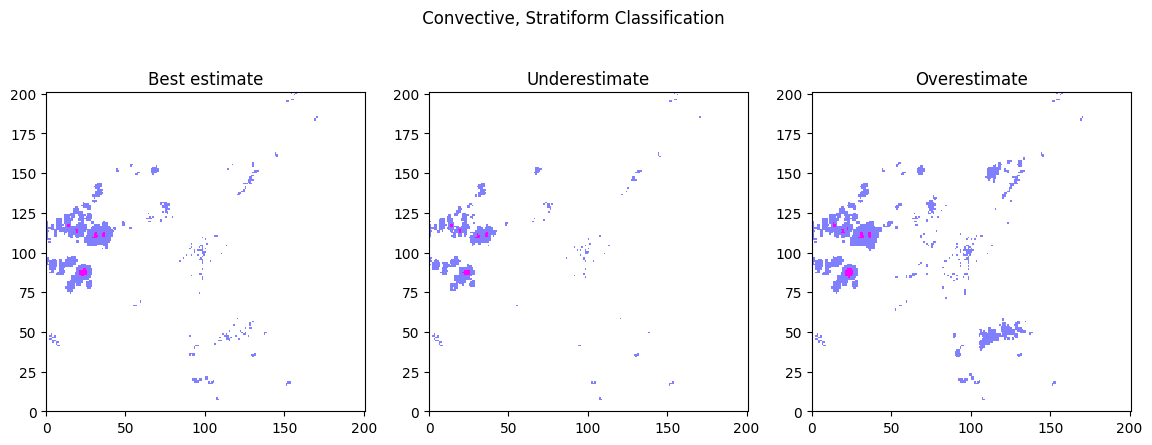

In [12]:
#Get a gist of the tollarances
# mask weak echo and no surface echo
convsf_masked = np.ma.masked_equal(convsf_dict["feature_detection"]["data"], 0)
convsf_masked = np.ma.masked_equal(convsf_masked, 3)
convsf_dict["feature_detection"]["data"] = convsf_masked
# underest.
convsf_masked = np.ma.masked_equal(convsf_dict["feature_under"]["data"], 0)
convsf_masked = np.ma.masked_equal(convsf_masked, 3)
convsf_dict["feature_under"]["data"] = convsf_masked
# overest.
convsf_masked = np.ma.masked_equal(convsf_dict["feature_over"]["data"], 0)
convsf_masked = np.ma.masked_equal(convsf_masked, 3)
convsf_dict["feature_over"]["data"] = convsf_masked

# Plot each estimation
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(131)
ax1.pcolormesh( convsf_dict["feature_detection"]["data"][0, :, :], vmin=0, vmax=2, cmap=plt.get_cmap("cool", 3),)
ax1.set_title("Best estimate")
ax1.set_aspect("equal")
ax2 = plt.subplot(132)
ax2.pcolormesh( convsf_dict["feature_under"]["data"][0, :, :], vmin=0, vmax=2, cmap=plt.get_cmap("cool", 3),)
ax2.set_title("Underestimate")
ax2.set_aspect("equal")
ax3 = plt.subplot(133)
ax3.pcolormesh(convsf_dict["feature_over"]["data"][0, :, :], vmin=0, vmax=2, cmap=plt.get_cmap("cool", 3),)
ax3.set_title("Overestimate")
ax3.set_aspect("equal")
plt.suptitle(" Convective, Stratiform Classification")
plt.show()

### Step 5: Calculate Hail parameters

In [13]:
#Having Assured there has been a Convective activity, extract additional details from Sounding data of closest location and time  
#Here we have taken Chennai [43279] GPS-GRAW Sonde data of 12.00UTC 

#A Heler function to interpolate values for a refered location
def sounding_interp(snd_temp, snd_height, target_temp):
    intp_h = np.nan
    # find index above and below freezing level
    mask = np.where(snd_temp < target_temp)
    above_ind = mask[0][0]
    # index below
    below_ind = above_ind - 1
    # apply linear interplation to points above and below target_temp
    set_interp = interp1d( snd_temp[below_ind : above_ind + 1], snd_height[below_ind : above_ind + 1],
        kind="linear",
    )
    # apply interpolant
    intp_h = set_interp(target_temp)
    return intp_h

#Read the sounding data and extract Zero degree C (Freezing Layer) Height and Minus 20 degree C heights
df = pd.read_csv('data/20240502_Sounding.csv',sep="\s+",usecols=range(3))  ##skiprows=5,  delimiter='\t', usecols=[0,1,2]
#df.dtypes
snd_temp=df['TEMP_C'].values 
snd_hght=df['HGHT_m'].values 
snd_pres=df['PRES_hPA'].values 
#print(snd_temp,snd_hght,snd_pres)
h_0deg=sounding_interp(snd_temp, snd_hght,0.0)
h_m20deg=sounding_interp(snd_temp, snd_hght,-20.0)

<head><h4>Assignment: <p> 5. Why do we require other than Radar Data?</p></h4>  </head>
<p> Hint:  Atmospheric variables that cannot be observed directly by Radar  </p>

In [14]:
#Using Pyhail find out the Maximum Expected Hail Size (MESH)
meshgrid_fields = mesh_grid.main(gridm, dbz_fname='reflectivity', levels=[h_0deg, h_m20deg], mesh_method='mh2019_75',  radar_band='S')
gridm.add_field('mesh_mh2019_75', meshgrid_fields['mesh_mh2019_75'], replace_existing=True)
meshgrid_fields = mesh_grid.main(gridm, dbz_fname='reflectivity', levels=[h_0deg, h_m20deg], mesh_method='mh2019_95',  radar_band='S')
gridm.add_field('mesh_mh2019_95 ', meshgrid_fields['mesh_mh2019_95'], replace_existing=True)
meshgrid_fields = mesh_grid.main(gridm, dbz_fname='reflectivity', levels=[h_0deg, h_m20deg], mesh_method='witt1998',  radar_band='S')
gridm.add_field('mesh_witt1998', meshgrid_fields['mesh_witt1998'], replace_existing=True)
#print(gridm.fields)

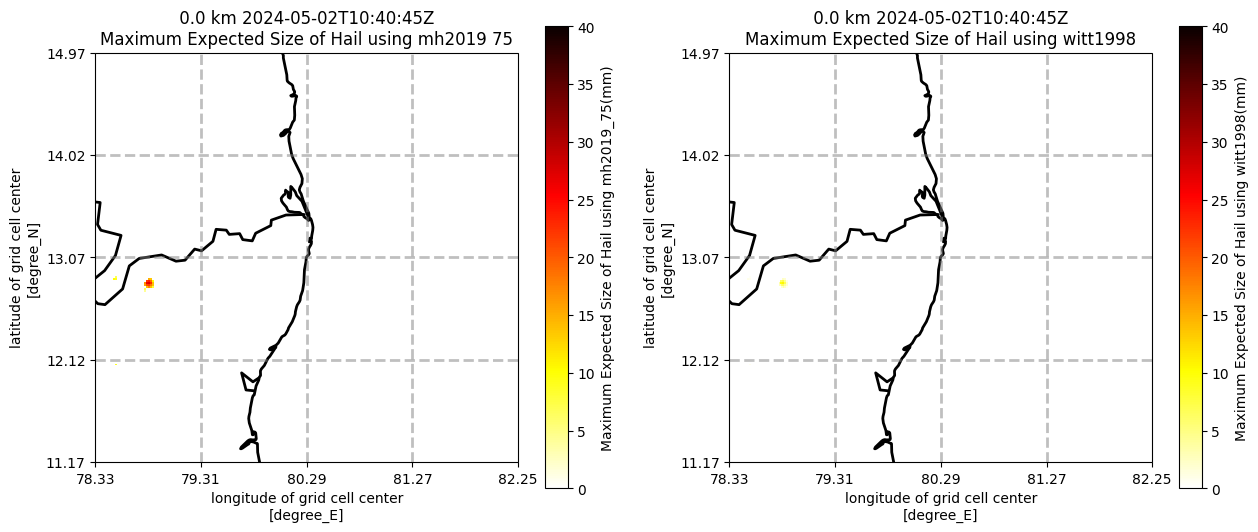

In [15]:
#Create a plot on the predictions
displaym = pyart.graph.GridMapDisplay(gridm)
projection=ccrs.PlateCarree()

plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1, projection=projection)
displaym.plot_grid( "mesh_mh2019_75", 0, vmin=0, vmax=40, cmap='hot_r', transform=projection, ax=ax1,)#cmap=ref_cmap 
#ax2 = plt.subplot(1, 2, 2, projection=projection)
#displaym.plot_grid( "mesh_mh2019_95", 0, vmin=10, vmax=50, cmap='hot_r', transform=projection, ax=ax2,)#cmap=ref_cmap 
ax3 = plt.subplot(1,2, 2, projection=projection)
displaym.plot_grid( "mesh_witt1998", 0, vmin=0, vmax=40, cmap='hot_r', transform=projection, ax=ax3,)#cmap=ref_cmap 


<head><h4>Assignment: <p>6. Comment on the three MESH Algorithms </p> </h4>  </head>
<p> Hint:  See below...  </p>

Text(0.5, 1.0, 'Comparison of the different MESH formulations')

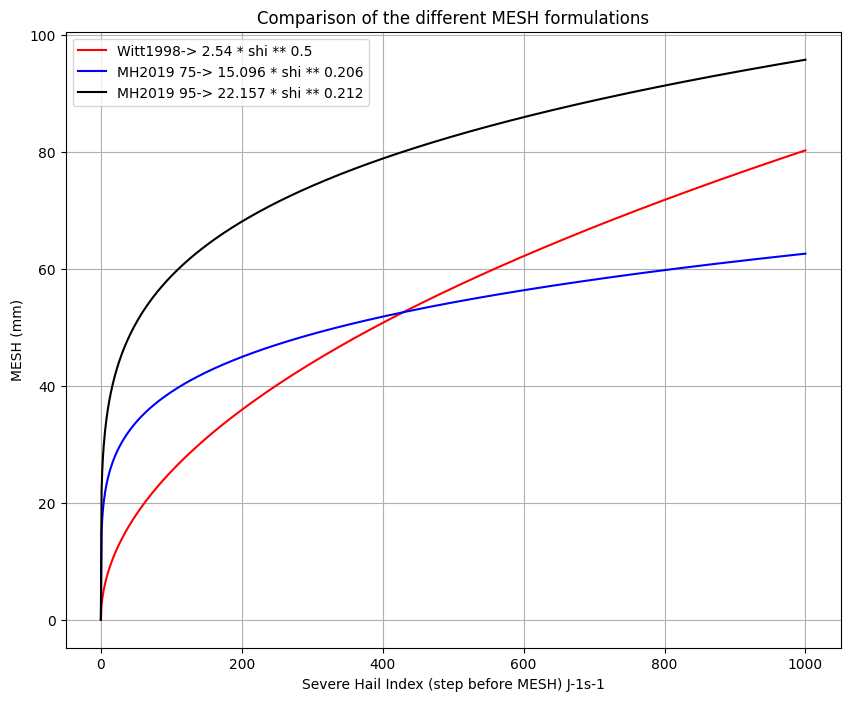

In [16]:
shi = np.arange(0,1001)

mesh_witt = 2.54 * shi ** 0.5
mesh_mh2019_75 = 15.096 * shi ** 0.206
mesh_mh2019_95 = 22.157 * shi ** 0.212

fig = plt.figure(figsize=(10,8))
plt.plot(shi,mesh_witt,'r-')
plt.plot(shi,mesh_mh2019_75,'b-')
plt.plot(shi,mesh_mh2019_95,'k-')
plt.xlabel('Severe Hail Index (step before MESH) J-1s-1')
plt.ylabel('MESH (mm)')
plt.grid()
plt.legend(['Witt1998-> 2.54 * shi ** 0.5', 'MH2019 75-> 15.096 * shi ** 0.206', 'MH2019 95-> 22.157 * shi ** 0.212'])
plt.title('Comparison of the different MESH formulations')

### Step 6: Other additional parameters derived from volume data

Text(0.5, 1.0, 'DWR-Chennai_VPR_20240502104045\n @(Lat, Lon): (12.8473,78.8299)')

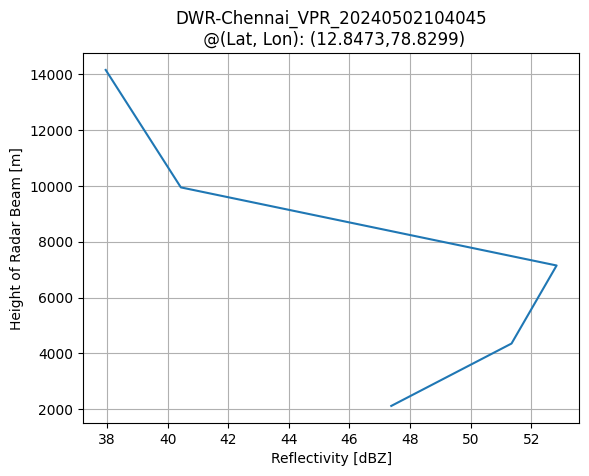

In [17]:
#VPR
hail_lon = 78.8299 #78.8311#  # longitude in degrees
hail_lat = 12.8473 #12.8288  # latitdue in degrees
ds = pyart.util.columnsect.get_field_location(radar, hail_lat, hail_lon)
ds.reflectivity.plot( y="height");
plt.grid()
plt.title("DWR-Chennai_VPR_"+Obs_time+"\n @(Lat, Lon): ("+str(hail_lat)+","+str(hail_lon)+")")
#plt.savefig("CNI_VPR_"+Obs_time+'.png',bbox_inches='tight')
#print(ds.reflectivity)
#ds

<head><h4>Assignment: <p>7. From the VPR find the Echo Top </p><p>8. Infer other related Parameters of Hail VIL / VIL density etc</p> </h4>  </head>
<p> Hint:  Parse through various levels...  </p>

<h1 style="color:tomato;"> <center> Any Queries/Doubts ??? <img src="data/Query.gif", width=10%,height=10%> </center>   </h1>

<h1 style="color:Blue;"><center>  <img src="data/150Yrs.jpeg", ,width=50%,height=50%> Have a Great Day... </center> </h1>
